**Aim:** transform championship matches as if they had been played against premier league strength teams. This is so they can be used alongside premier league historic matches in predicting upcoming scores in matches involving newly promoted teams.  We will predict average premier performance based on the average championship performance of each team.  We will then use this transformation on each championship match to bring it in line with typical values in the premier league.

As an example, a very simple model may predict that promoted teams tend to score an average of 1.5 goals at home in the premier league.  Using this model we would set the home goals in each championship match to 1.5.  We will investigate if we can make better predictions than a baseline of just the average of past promoted teams.

The match features we want to transform are:
* goals
* shots on target
* shots
* corners
* fouls
* yellow cards
* red cards

We will predict home and away versions of each feature for and against each team.  Each feature will therefore have 4 varieties - for example: home goals for, home goals against, away goals for and away goals against.

One problem here is that there are only ever 3 teams promoted per season, so even with 20 years of data we only have 60 data samples.  This makes it very easy to overfit to our training data.  We need to take extra precautions to ensure our models can generalise on unseen data. Some precautions we will take:
* focus on linear models which are less prone to overfitting
* keep models very simple by using at most 1 feature. For example, when predicting how many home goals a team is likely to score in the premier league we will only base this on home goals scored in the championship (rather than shots on target as well for example)
* ensure models are appropriately regularised through hyper parameter tuning.  Given we have already reduced the training features to 1, we will focus on L2 regularisation using Ridge regression

We can double the data if we include relegated teams as well, but they do not reflect exactly how promoted teams will perform.  We will investigate the impact of including relegated teams in our training samples as these teams give us more data to compare championship performance to premier league performance.

The performance of newly promoted teams can all vary over time, due to the strength and play styles of each division varying over time.  This means that older data is less valuable to us than the most recent data.  We will investigate weighting the samples to prioritise more recent seasons in model training.

We will use newly promoted teams in each season as the validation test samples and only train using team performances from earlier seasons.

Model options we will investigate:
* baseline: mean value of previous promoted teams
* average: average weighted value:
    * model options: mean or median
* ridge regression with the championship feature as the only training feature
    * regularisation parameter: 15 values between 0.0001 and 1000 (on a logarithmic scale)
        
For the average and ridge models we will investigate the impact of the following sample weightings:
* uweighted
* 16 season half life - i.e. each season is worth double the season 16 years ago
* 8 season half life - i.e. each season is worth double the season 8 years ago
* 4 season half life - i.e. each season is worth double the season 4 years ago
* 2 season half life - i.e. each season is worth double the season 2 years ago
* 1 season half life - i.e. each season is worth double the previous season

For the average and ridge models we will investigate the impact of the following training samples:
* previous promoted teams only
* previous promoted and relegated teams

To reproduce the steps in this notebook:
1. make sure the steps from the 001 notebook have been followed first
1. run "make train_championship_transformation" in a terminal opened at the location of the repository
    * this will carry out the model training and selection steps from this notebook

In [1]:
# common notebook config
%run notebook-config.ipynb

autoreload enabled
numpy imported as np (1.19.5)
pandas imported as pd (1.2.1)
Pandas display: Remove maximum column width
Pandas display: Show up to 100 columns in tables
Pandas display: Show up to 100 rows in tables
Pandas display: Set floats to show up to 3 decimal places
matplotlib: show plots inline
matplotlib imported as mpl (3.3.3)
matplotlib.pyplot imported as plt
matplotlib: use ggplot style
seaborn: set white grid theme
Logging: show log messages in ipython


In [2]:
from src.models import train_championship_transformation

In [3]:
interim_filepath = "../data/interim"
models_filepath = "../models"

## Calculate season summaries

We have already downloaded and cleaned the match data from the 2000/2001 season onwards, so it is ready for us to create a season summary table.  Each row of the table will contain the average performance of each team per season.  We will include their performance from the previous season as well.

In [4]:
train_championship_transformation.calculate_season_summaries(interim_filepath)

Calculating season summaries...
Saved file: ../data/interim/season_summaries.csv
Calculated season summaries!


In [5]:
# View a sample of the generated season summaries
season_summaries = pd.read_csv("{}/season_summaries.csv".format(interim_filepath))
season_summaries.sample(10)

,team,season,division,home_corners_against_mean,home_corners_for_mean,home_fouls_against_mean,home_fouls_for_mean,home_goals_against_mean,home_goals_for_mean,home_redCards_against_mean,home_redCards_for_mean,home_shotsOnTarget_against_mean,home_shotsOnTarget_for_mean,home_shots_against_mean,home_shots_for_mean,home_yellowCards_against_mean,home_yellowCards_for_mean,away_corners_against_mean,away_corners_for_mean,away_fouls_against_mean,away_fouls_for_mean,away_goals_against_mean,away_goals_for_mean,away_redCards_against_mean,away_redCards_for_mean,away_shotsOnTarget_against_mean,away_shotsOnTarget_for_mean,away_shots_against_mean,away_shots_for_mean,away_yellowCards_against_mean,away_yellowCards_for_mean,home_goals_for_mean_previous,home_shots_for_mean_previous,home_shotsOnTarget_for_mean_previous,home_corners_for_mean_previous,home_fouls_for_mean_previous,home_yellowCards_for_mean_previous,home_redCards_for_mean_previous,home_goals_against_mean_previous,home_shots_against_mean_previous,home_shotsOnTarget_against_mean_previous,home_corners_against_mean_previous,home_fouls_against_mean_previous,home_yellowCards_against_mean_previous,home_redCards_against_mean_previous,away_goals_for_mean_previous,away_shots_for_mean_previous,away_shotsOnTarget_for_mean_previous,away_corners_for_mean_previous,away_fouls_for_mean_previous,away_yellowCards_for_mean_previous,away_redCards_for_mean_previous,away_goals_against_mean_previous,away_shots_against_mean_previous,away_shotsOnTarget_against_mean_previous,away_corners_against_mean_previous,away_fouls_against_mean_previous,away_yellowCards_against_mean_previous,away_redCards_against_mean_previous,season_previous,division_previous
583,Norwich,2018,championship,3.783,7.174,15.870,11.130,1.478,2.217,0.043,0.043,3.652,5.565,10.304,16.304,2.130,1.348,5.174,6.000,13.826,12.043,1.000,1.826,0.000,0.000,4.783,5.478,14.304,14.261,1.783,2.043,1.087,15.652,4.174,6.435,12.304,1.696,0.000,1.087,11.087,3.783,4.174,15.087,2.696,0.087,1.043,12.609,3.870,4.261,12.217,2.217,0.043,1.522,14.870,4.870,4.696,13.478,2.000,0.000,2017.000,championship
373,Hull,2008,premier,5.421,5.526,12.263,13.474,1.895,0.947,0.158,0.158,5.947,5.526,12.263,11.053,1.579,1.526,8.579,4.368,12.579,14.579,1.474,1.105,0.053,0.000,8.842,5.684,16.474,10.842,1.526,2.263,1.870,13.304,6.652,5.652,12.957,1.174,0.130,0.826,8.609,4.304,4.348,12.478,1.348,0.304,0.957,11.130,5.783,5.304,13.304,1.957,0.043,1.217,9.826,5.348,5.652,12.522,1.478,0.174,2007.000,championship
46,Barnsley,2008,championship,5.261,5.217,13.217,13.261,1.043,1.217,0.174,0.130,4.304,5.783,8.391,11.261,1.261,1.783,5.957,4.217,11.826,15.783,1.478,0.739,0.000,0.087,7.435,5.783,14.348,10.696,1.087,1.565,1.522,12.087,6.348,5.652,11.565,1.087,0.087,1.130,11.565,6.261,7.565,13.174,1.435,0.043,0.739,8.957,4.130,4.304,13.565,2.000,0.174,1.696,13.696,6.609,7.826,10.565,1.043,0.043,2007.000,championship
442,Liverpool,2000,premier,3.895,7.632,11.421,11.526,0.737,2.105,0.105,0.105,4.105,7.474,8.263,14.842,1.579,1.105,5.947,5.158,12.737,13.368,1.316,1.632,0.158,0.105,5.105,5.632,9.684,10.842,1.526,1.526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
602,Nott'm Forest,2019,championship,5.087,6.652,12.000,10.870,1.174,1.174,0.174,0.000,3.565,3.478,11.000,14.087,1.826,1.478,7.304,4.391,11.087,11.957,1.000,1.348,0.087,0.043,4.043,3.174,14.261,11.478,1.696,1.957,1.478,13.348,3.739,4.391,13.391,2.043,0.000,0.913,10.652,4.087,4.913,12.652,1.261,0.043,1.174,11.130,4.087,4.652,13.652,2.391,0.217,1.435,15.000,4.826,6.217,11.957,1.783,0.000,2018.000,championship
403,Ipswich,2018,championship,4.739,4.913,12.174,13.739,1.348,0.957,0.130,0.130,3.522,3.043,13.043,10.435,1.783,1.739,6.043,4.391,11.826,14.174,2.000,0.609,0.000,0.130,5.087,2.826,14.783,9.391,1.348,1.478,1.261,11.609,4.043,5.043,11.826,1.522,0.043,1.174,15.261,4.391,5.565,11.609,1.261,0.087,1.217,8.739,2.652,4.870,14.130,2.304,0.043,1.435,15.217,4.957,6.565,12.565,1.391,0.0

## Separate promoted and relegated team season summaries

In [6]:
train_championship_transformation.separate_promoted_and_relegated_season_summaries(interim_filepath)

Separating promoted & relegated season summaries...
Saved file: ../data/interim/promoted_season_summaries.csv
Saved file: ../data/interim/promoted_and_relegated_season_summaries.csv
Separated promoted, and promoted & relegated season summaries!


In [7]:
# View the promoted teams' season summaries from 2001 to 2003
promoted_season_summaries = pd.read_csv("{}/promoted_season_summaries.csv".format(interim_filepath))

gradient_columns = ["home_goals_for_mean_championship", "home_goals_for_mean_premier"]
show_columns = ["team", "season"] + gradient_columns

promoted_season_summaries[show_columns].head(9).style.background_gradient(subset=gradient_columns, axis=None)
# This shows their average goals in the last championship season before promotion
#  and in the first premier season after promotion
# The season year shown is the one after promotion

,team,season,home_goals_for_mean_championship,home_goals_for_mean_premier
0,Blackburn,2001,1.869565,1.736842
1,Bolton,2001,1.739130,1.052632
2,Fulham,2001,2.130435,1.105263
3,Birmingham,2002,1.913043,1.315789
4,Man City,2002,2.739130,1.473684
5,West Brom,2002,1.565217,0.894737
6,Leicester,2003,1.739130,1.000000
7,Portsmouth,2003,2.260870,1.842105
8,Wolves,2003,1.739130,1.210526


In [8]:
# View the relegated teams' season summaries from 2001 to 2003
promoted_and_relegated_season_summaries = pd.read_csv("{}/promoted_and_relegated_season_summaries.csv".format(interim_filepath))

# this dataframe also includes the promoted teams, so we will filter to just the relegated teams
relegated_season_summaries = promoted_and_relegated_season_summaries[
    (promoted_and_relegated_season_summaries.division == "championship") &
    (promoted_and_relegated_season_summaries.division_previous == "premier")
]

gradient_columns = ["home_goals_for_mean_premier", "home_goals_for_mean_championship"]
show_columns = ["team", "season"] + gradient_columns

relegated_season_summaries[show_columns].head(9).style.background_gradient(subset=gradient_columns, axis=None)
# This shows their average goals in the last premier season before relegation and
#  in the first championship season after relegation
# The season year shown is the one after relegation

,team,season,home_goals_for_mean_premier,home_goals_for_mean_championship
0,Bradford,2001,1.052632,1.782609
1,Coventry,2001,0.736842,1.434783
2,Man City,2001,1.052632,2.739130
6,Derby,2002,1.052632,1.434783
7,Ipswich,2002,1.052632,2.130435
8,Leicester,2002,0.789474,1.739130
12,Sunderland,2003,0.578947,1.434783
13,West Brom,2003,0.894737,1.478261
14,West Ham,2003,1.105263,1.826087


## Train models

Next, we will train each of the model combinations outlined above. For each we will calculate the mean squared error (MSE) on the promoted teams from the next season.

In [9]:
# this step can take a few minutes to run
train_championship_transformation.train_models(interim_filepath, models_filepath)

Training championship transformation model: Baseline
Training for Promoted teams
Training Baseline 2002/2020
Training Baseline 2003/2020
Training Baseline 2004/2020
Training Baseline 2005/2020
Training Baseline 2006/2020
Training Baseline 2007/2020
Training Baseline 2008/2020
Training Baseline 2009/2020
Training Baseline 2010/2020
Training Baseline 2011/2020
Training Baseline 2012/2020
Training Baseline 2013/2020
Training Baseline 2014/2020
Training Baseline 2015/2020
Training Baseline 2016/2020
Training Baseline 2017/2020
Training Baseline 2018/2020
Training Baseline 2019/2020
Training Baseline 2020/2020
Training Baseline Completed!
Training championship transformation model: Average
Training for Promoted teams
Training Average 2002/2020
Training Average 2003/2020
Training Average 2004/2020
Training Average 2005/2020
Training Average 2006/2020
Training Average 2007/2020
Training Average 2008/2020
Training Average 2009/2020
Training Average 2010/2020
Training Average 2011/2020
Training

## Model selection

For each model combination we will predict the MSE in the upcoming season by averaging the MSE from previous seasons.  The best parameter combination will be selected for each model based on the lowest predicted MSE - we will call this the base predicted MSE.

The model performance will then be predicted based on how the tuned model has performed on previous seasons - we will call this the model predicted MSE.

The reason for having a separate model predicted MSE is that the base predicted MSE can be too optimistic and has a higher chance of selecting a parameter combination from a model with more options.  Tuning the models first and then selecting from the tuned models means that each model is on a level playing field and the predicted performance also considers how the tuning process has previously performed.

In [10]:
train_championship_transformation.select_best_models(models_filepath)

Selecting best models...
Saved file: ../models/championship_transformation_selected_models.csv
Saved file: ../models/championship_transformation_best_models.csv
Best models selected!


## Analyse selected models

In [11]:
models_df = pd.read_csv("{}/championship_transformation_selected_models.csv".format(models_filepath))

# Calculate root mean squared error which has the same units as the target variables
models_df["rmse"] = np.sqrt(models_df["mse"])

# predicted performance based on how the specific parameters have fared in previous seasons
models_df["base_predicted_rmse"] = np.sqrt(models_df["base_predicted_mse"])

# predicted performance based on how the tuned model has fared in previous seasons
models_df["model_predicted_rmse"] = np.sqrt(models_df["model_predicted_mse"])

In [13]:
# Review the tuned model average performance in latest 10 years
# The selected model is the tuned model we have predicted to perform the best in the upcoming season

mean_performance_df = pd.DataFrame(columns=["target_variable", "baseline_mean_rmse", "average_mean_rmse", "ridge_mean_rmse", "selected_mean_rmse"])

for target_variable in models_df.target_variable.unique():
    df = models_df[
        (models_df.tuned_model) &
        (models_df.target_variable == target_variable) &
        (models_df.season >= 2010) &
        (models_df.season < 2020)
    ]
    baseline_mean_rmse = df[(df.model_name == "Baseline")].rmse.mean()
    selected_mean_rmse = df[(df.best_model == True)].rmse.mean()
    mean_performance_df = mean_performance_df.append({
        "target_variable": target_variable,
        "baseline_mean_rmse": baseline_mean_rmse,
        "average_mean_rmse": df[(df.model_name == "Average")].rmse.mean(),
        "ridge_mean_rmse": df[(df.model_name == "Ridge")].rmse.mean(),
        "selected_mean_rmse": selected_mean_rmse
    }, ignore_index=True)
    
mean_performance_df = mean_performance_df.append({
    "target_variable": "Mean of all",
    "baseline_mean_rmse": mean_performance_df.baseline_mean_rmse.mean(),
    "average_mean_rmse": mean_performance_df.average_mean_rmse.mean(),
    "ridge_mean_rmse": mean_performance_df.ridge_mean_rmse.mean(),
    "selected_mean_rmse": mean_performance_df.selected_mean_rmse.mean()
}, ignore_index=True)
    
mean_performance_df.style.background_gradient(axis=1)

,target_variable,baseline_mean_rmse,average_mean_rmse,ridge_mean_rmse,selected_mean_rmse
0,away_corners_against_mean_premier,0.777612,0.779773,0.749226,0.802014
1,away_corners_for_mean_premier,0.613896,0.574189,0.577938,0.573348
2,away_fouls_against_mean_premier,1.772308,1.397642,1.354941,1.470007
3,away_fouls_for_mean_premier,2.031477,1.371388,1.396364,1.396364
4,away_goals_against_mean_premier,0.302154,0.318792,0.311932,0.318696
5,away_goals_for_mean_premier,0.250471,0.257475,0.254677,0.250471
6,away_redCards_against_mean_premier,0.057077,0.057013,0.058260,0.057013
7,away_redCards_for_mean_premier,0.053105,0.058294,0.055284,0.053105
8,away_shotsOnTarget_against_mean_premier,2.287664,1.819808,1.667683,1.705830
9,away_shotsOnTarget_for_mean_premier,1.402154,0.921246,0.920510,1.043301


In general the selected tuned models perform noticeably better than the baseline or only slightly worse.

There are some features where the selected model has performed worse than the baseline model. The most noticeable is home corners against.  We can investigate further by graphing the model performances over each season.

In [14]:
def plot_feature_model_comparison(feature, plot_value="rmse", from_season=2003, to_season=2019):
    df = models_df[
        (models_df.target_variable == feature) &
        (models_df.season >= from_season) &
        (models_df.season <= to_season)
    ]

    tuned_model_df = df[
        (df.tuned_model == True)
    ]
    
    best_model_df = df[
        (df.best_model == True)
    ]
    
    models = ["Baseline", "Average", "Ridge"]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [2, 1]}, figsize=(18,6))
    fig.suptitle(feature, fontsize=14)

    sns.lineplot(x="season", y=plot_value, data=tuned_model_df, hue="model_name", hue_order=models, ax=ax1)
    sns.scatterplot(x="season", y=plot_value, data=best_model_df, hue="model_name", hue_order=models, style="model_name", style_order=models, s=100, ax=ax1)
    sns.boxplot(x="model_name", y=plot_value, data=tuned_model_df, hue="model_name", hue_order=models, ax=ax2)
    
    fig.autofmt_xdate(rotation=45)
    plt.show()

def plot_best_models_comparison(plot_value="rmse", from_season=2003, to_season=2019):
    for target_variable in train_championship_transformation.PREMIER_COLUMNS:
        plot_feature_model_comparison(target_variable, plot_value=plot_value, from_season=from_season, to_season=to_season)

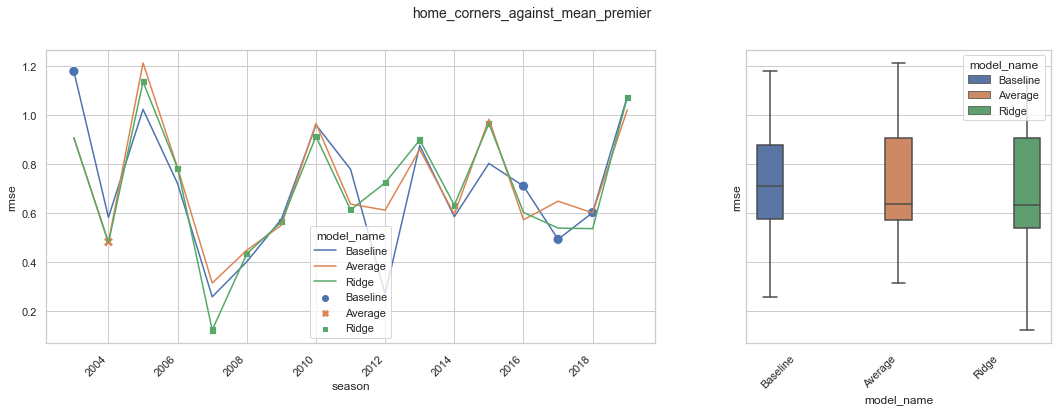

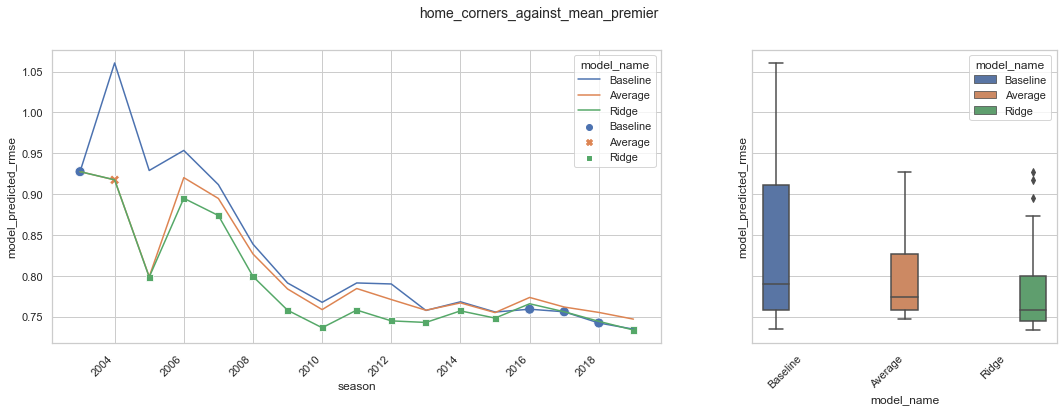

In [15]:
plot_feature_model_comparison(feature="home_corners_against_mean_premier", plot_value="rmse")
plot_feature_model_comparison(feature="home_corners_against_mean_premier", plot_value="model_predicted_rmse")
# The larger markers identify which model type was chosen each season as the best model
#  (based on lowest model predicted MSE)

We can see that the performance has been very similar between each of the models.  The baseline model had a poor performance in 2003 which would have affected the model selection process and made it less likely to be selected afterwards.  The model selection process could be improved by weighting more recent seasons more highly in the aggregation or ignoring earlier season altogether.  The earlier seasons have very little data to go on and so will be prone to larger errors which can skew the performance predictions.

In the later seasons the baseline and ridge model have very similar predicted RMSE.  It could be beneficial to prioritise the simpler baseline model when the predicted performances are very similar.

Out of interest, we can look at what the base predicted errors would have been for home corners against.

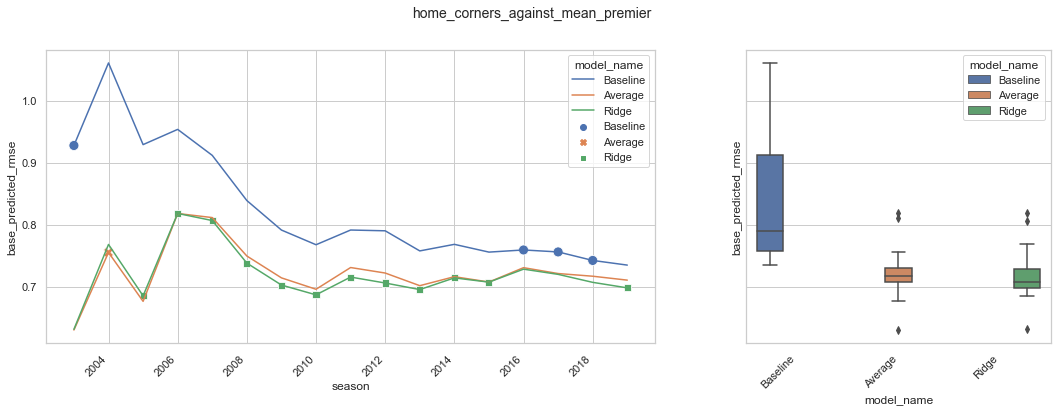

In [16]:
plot_feature_model_comparison(feature="home_corners_against_mean_premier", plot_value="base_predicted_rmse")

The base predicted RMSE are more optimistic than the model predicted RMSE and the average and ridge models have noticeably better predicted performances than the baseline model.  This is largely due to the fact they have more parameter combinations which have been tried.

Next we can look at the specific parameters which were chosen each season for predicting home corners against.

In [17]:
display(models_df[
    (models_df.best_model) &
    (models_df.target_variable == "home_corners_against_mean_premier") &
    (models_df.season > 2002) &
    (models_df.season < 2020)
][["season", "model_name", "training_sample", "weighting_column", "parameters", "intercept", "coefficient", "rmse", "model_predicted_rmse", "base_predicted_rmse"]].style.background_gradient(axis=None, subset=["rmse", "model_predicted_rmse", "base_predicted_rmse"]))

,season,model_name,training_sample,weighting_column,parameters,intercept,coefficient,rmse,model_predicted_rmse,base_predicted_rmse
54735,2003,Baseline,Promoted,unweighted,{},4.903509,0.000000,1.178740,0.927505,0.927505
54956,2004,Average,Promoted & Relegated,16_season_half_life_weight,{'strategy': 'median'},5.631579,0.000000,0.481418,0.917432,0.755100
55335,2005,Ridge,Promoted & Relegated,1_season_half_life_weight,{'alpha': 1000.0},5.417482,0.011877,1.136254,0.798423,0.685199
55465,2006,Ridge,Promoted & Relegated,unweighted,{'alpha': 1000.0},5.366305,0.004290,0.783735,0.894918,0.818001
55747,2007,Ridge,Promoted & Relegated,1_season_half_life_weight,{'alpha': 100.0},3.557108,0.328759,0.122234,0.873814,0.806536
55952,2008,Ridge,Promoted & Relegated,1_season_half_life_weight,{'alpha': 100.0},3.283788,0.425210,0.433595,0.799239,0.737952
56157,2009,Ridge,Promoted & Relegated,1_season_half_life_weight,{'alpha': 100.0},3.891614,0.281929,0.563723,0.757882,0.702591
56362,2010,Ridge,Promoted & Relegated,1_season_half_life_weight,{'alpha': 100.0},4.148899,0.242472,0.912925,0.736417,0.686770
56567,2011,Ridge,Promoted & Relegated,1_season_half_life_weight,{'alpha': 100.0},2.637903,0.589335,0.613038,0.758062,0.715438
56772,2012,Ridge,Promoted & Relegated,1_season_half_life_weight,{'alpha': 100.0},2.865598,0.613064,0.723541,0.744831,0.705866


The models have struggled to settle on a single set of parameters.  The home corners against may be much more dependant on the playstyle of premier league teams than anything to do with how the newly promoted team plays in general.

The model selection has not chosen the best models in each case, but we do not want to try multiple selection methods and end up with optimistically performing models of how the promoted teams will perform.  It will be useful to have these errors in our overall match dataset later in giving us more realistic errors of how the match prediction models will perform.

For comparison we can look at one of the features where the model selection process has been effective - home shots on target for.

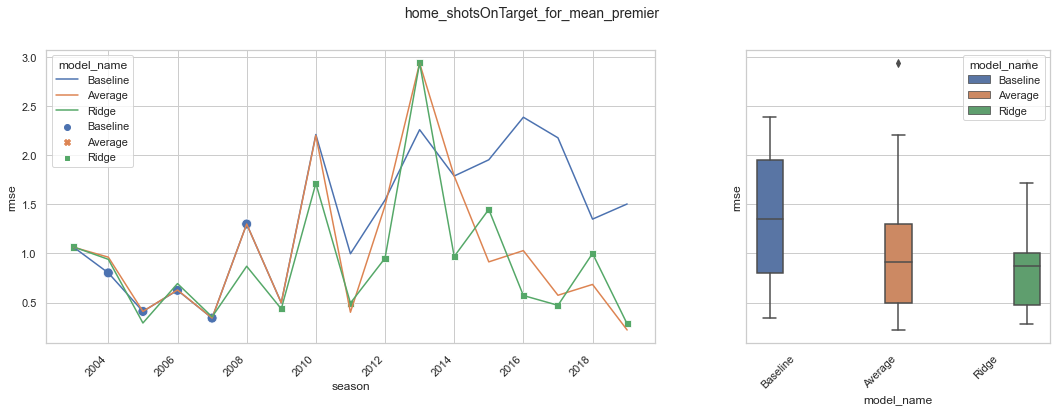

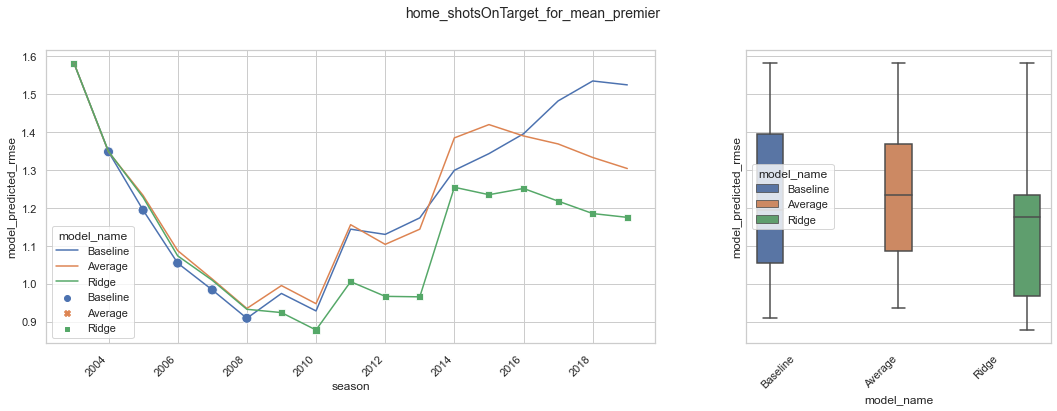

In [18]:
target_variable = "home_shotsOnTarget_for_mean_premier"
plot_feature_model_comparison(target_variable, plot_value="rmse")
plot_feature_model_comparison(target_variable, plot_value="model_predicted_rmse")

Each of the models performed similar to each other in the earlier seasons when there were only small training samples.  We can see that the ridge model begins to perform noticeably better in the later seasons and the selection process identifies this and decides to use this model consistently after 2008.

Let's look at the specific tuned models selected each season.

In [19]:
display(models_df[
    (models_df.best_model) &
    (models_df.target_variable == target_variable) &
    (models_df.season > 2002) &
    (models_df.season < 2020)
][["season", "model_name", "training_sample", "weighting_column", "parameters", "intercept", "coefficient", "rmse", "model_predicted_rmse", "base_predicted_rmse"]].style.background_gradient(axis=None, subset=["rmse", "model_predicted_rmse", "base_predicted_rmse"]))

,season,model_name,training_sample,weighting_column,parameters,intercept,coefficient,rmse,model_predicted_rmse,base_predicted_rmse
89819,2003,Ridge,Promoted,unweighted,{'alpha': 10.0},3.902119,0.252236,1.065846,1.582463,1.566365
89995,2004,Baseline,Promoted,unweighted,{},5.894737,0.000000,0.802236,1.348098,1.348098
90200,2005,Baseline,Promoted,unweighted,{},5.785088,0.000000,0.410152,1.194197,1.194197
90405,2006,Baseline,Promoted,unweighted,{},5.810526,0.000000,0.624877,1.054341,1.054341
90610,2007,Baseline,Promoted,unweighted,{},5.783626,0.000000,0.342492,0.983566,0.983566
90815,2008,Baseline,Promoted,unweighted,{},5.807018,0.000000,1.299667,0.908691,0.908691
91049,2009,Ridge,Promoted,unweighted,{'alpha': 10.0},3.277336,0.372170,0.436217,0.923747,0.886406
91254,2010,Ridge,Promoted,unweighted,{'alpha': 10.0},3.342222,0.369401,1.712897,0.877742,0.843379
91519,2011,Ridge,Promoted,2_season_half_life_weight,{'alpha': 10.0},1.492206,0.694247,0.495466,1.005400,0.955047
91724,2012,Ridge,Promoted,2_season_half_life_weight,{'alpha': 10.0},1.841089,0.654471,0.952131,0.966589,0.919485


There is a clear preference for excluding relegated teams from the training sample and using a regularisation parameter of 3 to 10 for the ridge regression.  Interestingly, it has selected either a completely unweighted sample or one with a 2 season half-life.  The low half life suggests that the shots on target will be largely affected by the current strength and playing style of other teams in the premier league.

There are some negative intercept parameters for the linear models here which will result in some negative shots on target in the final transformed data.  This is not an issue as we will be aggregating over a number of matches and these will be averaged out with positive values.

## Next steps
* In the next notebook we will use these models to generate an overall dataset of premier and championship matches.  The championship matches will be scaled as if they were played against premier league level teams and so we can use them as if they were previous premier league matches.
* We can then use that dataset to predict premier league match scores:
    * Investigate autocorrelation of historic match features on upcoming matches.  In other words, identify how we can use previous matches to predict what is likely to happen in upcoming matches.
    * Investigate the use of principal component analysis to reduce the match features in to a smaller set of features which explain the variance in goals scored.
    * Investigate a range of models for predicting goals scored based on historic match performances and identify which ones are most effective.